<a href="https://colab.research.google.com/github/sumunoh/study_assemble/blob/main/dl_using_a_pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#VGG16 만들어 보기
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights= 'imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# 데이터 증식을 사용하지 않는 빠른 특성 추출

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/ColabNotebooks/dl/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir,'test')

datagen = ImageDataGenerator(rescale=1./255) 
batch_size =20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count,4,4,512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size = (150,150),
      batch_size = batch_size,
      class_mode = 'binary')
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i+1) * batch_size] = features_batch
    labels[i * batch_size : (i+1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels
  
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)  

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_features.shape
validation_features.shape

(1000, 4, 4, 512)

In [ ]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))

In [ ]:
train_features.shape

(2000, 8192)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss='binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels,
                    epochs =30,
                    batch_size=20,
                    validation_data=(validation_features,validation_labels))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
100/100 [==============================] - 1s 9ms/step - loss: 0.4975 - acc: 0.7785 - val_loss: 0.3993 - val_acc: 0.8350
Epoch 2/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3375 - acc: 0.8650 - val_loss: 0.3203 - val_acc: 0.8800
Epoch 3/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2757 - acc: 0.9020 - val_loss: 0.2885 - val_acc: 0.8880
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2385 - acc: 0.9165 - val_loss: 0.2748 - val_acc: 0.8890
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2130 - acc: 0.9285 - val_loss: 0.2697 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.1933 - acc: 0.9330 - val_loss: 0.2513 - val_acc: 0.9020
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 0.1779 - acc: 0.9420 - val_loss: 0.2603 - val_acc: 0.8980
Epoch 8/30
100/100 [==============================] - 1s 7ms/step - loss: 0.

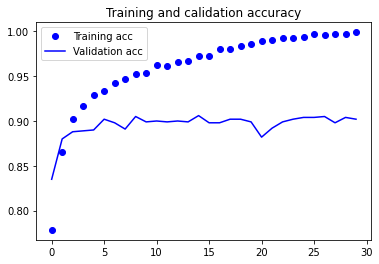

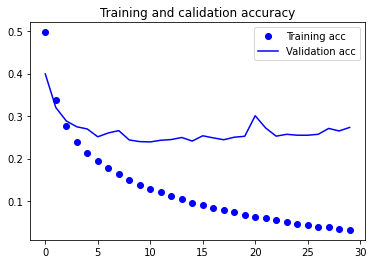

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and calidation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and calidation accuracy')
plt.legend()

plt.show()